<a href="https://colab.research.google.com/github/L1ght25/Autoencoder_hw/blob/master/autoencoders_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders

В этом ноутбуке мы будем тренировать автоэнкодеры кодировать лица людей. Для этого возьмем следующий датасет: "Labeled Faces in the Wild" (LFW) (http://vis-www.cs.umass.edu/lfw/). Код для скачивания и загрузки датасета написан за вас в файле get_dataset.py


# Vanilla Autoencoder (2 балла)

## Prepare the data


In [ ]:
!pip install scipy==1.1.0 # Для правильного импорта датасета лиц

!pip install scikit-learn==0.16.1 # Для правильной работы LSHForest

     |████████████████████████████████| 31.2MB 97kB/s 
ERROR: umap-learn 0.4.4 has requirement scipy>=1.3.1, but you'll have scipy 1.1.0 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement scipy==1.4.1; python_version >= "3", but you'll have scipy 1.1.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
     |████████████████████████████████| 7.3MB 8.7MB/s 
  Created wheel for scikit-learn: filename=scikit_learn-0.16.1-cp36-cp36m-linux_x86_64.whl size=7301324 sha256=d57186d6a9f3fecbbf9b6fb483cc03d4b871619990ce5e787e353db8eda913d1
  Stored in directory: /root/.cache/pip/wheels/7a/b6/39/1d54c9badbe43b63c939f2d47a9d90c545506b99e6bf73691f
Successfully built scikit-learn
ERRO

In [ ]:
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from get_dataset import fetch_dataset
data, attrs = fetch_dataset()

In [ ]:
IMAGE_H = data.shape[1]
IMAGE_W = data.shape[2]
# у нас цветные изображения
N_CHANNELS = 3

TRAIN_SIZE = 10000
VAL_SIZE = data.shape[0] - TRAIN_SIZE


Разбейте выборку картинок на train и val:

In [ ]:
X_train = data[:TRAIN_SIZE]
X_val = data[TRAIN_SIZE:]

Напишем вспомогательную функцию, которая будет выводить n_row $\cdot$ n_col первых картинок в массиве images:

In [ ]:
def plot_gallery(images, h, w, n_row=3, n_col=6, mode = None): # Добавил несколько строчек, чтобы потом можно было выводить нормализованные тензоры
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    if mode == 'tensor' or mode == 'MNIST':
        images = np.array(images, dtype='float32')
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        if mode == 'tensor':
            inp = images[i]
            mean = np.array((0.5,0.5,0.5))
            std = np.array((0.5,0.5,0.5))
            inp = std * inp + mean
        elif mode == 'MNIST':
            inp = images[i].reshape((h, w))
        else:
            inp = images[i].reshape((h, w, 3))
        try:
            plt.imshow(inp, cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            plt.xticks(())
            plt.yticks(())
        except:
            pass

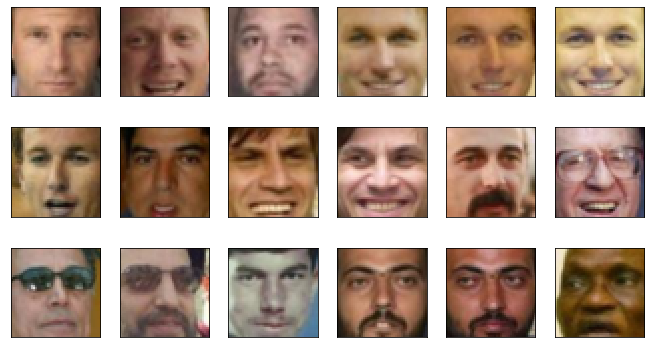

In [ ]:
plot_gallery(X_train, IMAGE_H, IMAGE_W)

Осталось привести картинки к тензорам из PyTorch, чтобы можно было потом скармливать их автоэнкодеру: 

In [ ]:
from torchvision import transforms
def to_tensor(dataset):
    transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
            ])
    new_set = []
    for i in range(len(dataset)):
        x = np.array(dataset[i].transpose((0, 1, 2)) / 255, dtype='float32')
        new_set.append(transform(x))
    return torch.stack(new_set).permute(0, 2, 3, 1)

X_train = to_tensor(X_train)
X_val = to_tensor(X_val)

## Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:
<img src="https://i.imgur.com/nVJAtMT.png" alt="Autoencoder">

In [ ]:
inp_size=X_train.shape[1]
dim_code = 100 # размер латентного вектора, т.е. code

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
from copy import deepcopy
import torch.nn as nn
import torch.optim as optim

class Autoencoder(nn.Module):
    def __init__(self, dim_code, inp_size):
#         <определите архитектуры encoder и decoder>
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(inp_size * inp_size * N_CHANNELS, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, dim_code)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(dim_code, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, inp_size * inp_size * N_CHANNELS),
        )
        
    def forward(self, x):
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        
#         <реализуйте forward проход автоэнкодера
#         в качестве ваозвращаемых переменных -- латентное представление картинки (latent_code) 
#         и полученная реконструкция изображения (reconstruction)>
        
        return reconstruction, latent_code

In [ ]:
device = torch.device("cuda")   

In [ ]:
criterion_vanilla = nn.MSELoss()

autoencoder_vanilla = Autoencoder(dim_code, inp_size).to(device)

optimizer_vanilla = optim.Adam(autoencoder_vanilla.parameters(), lr = 0.0001) # <Ваш любимый оптимизатор>

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

Подсказка: если x_val -- каринка, а reconstruction -- ее реконструкция автоэнкодером, то красиво вывести эту каритинку и ее реконструкцию можно с помощью функции plot_gallery вот так:

*plot_gallery([x_val, reconstruction], image_h, image_w, n_row=1, n_col=2)*

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
# <тут Ваш код тренировки автоэнкодера>

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
device

device(type='cuda')

In [ ]:
from IPython.display import clear_output

def train(autoencoder, data, val_data, epochs, loss_func, opt, batch_size, mode = 'vanilla', val_data_true = None):
    
    dataloader = DataLoader(data, batch_size = batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size = batch_size, shuffle=False)
    if mode == 'noisy_occ':
      true_loader = DataLoader(val_data_true, batch_size = batch_size, shuffle=False)

    train_losses = []
    validation_losses = []
    
    for i in range(epochs):
        running_loss = 0.0
        processed_data = 0

        autoencoder.train()
        if mode == 'noisy_occ':
          it = iter(true_loader)
        for batch in dataloader:
            if mode == 'vanilla':
                batch = batch.to(device)
                batch = batch.view(batch.size(0), 45 * 45 * 3)
            elif mode == 'VAE':
                batch = batch[0].to(device)
                batch = batch.view(batch.size(0), 28 * 28 * 1)
            elif mode == 'CVAE':
                cond = one_hot(batch[1], cond_dim).to(device)
                batch = batch[0].to(device)
                batch = batch.view(batch.size(0), 28 * 28 * 1)
            elif mode == 'noisy_occ':
                true = batch.transpose(0, 1)[1].to(device)
                batch = batch.transpose(0, 1)[0].to(device)
                batch = batch.view(batch.size(0), 45 * 45 * 3)
                true = true.view(true.size(0), 45 * 45 * 3)
            opt.zero_grad()
            if mode == 'vanilla':
                output = autoencoder(batch)
                loss = loss_func(output[0], batch)
            elif mode == 'noisy_occ':
                output = autoencoder(batch)
                loss = loss_func(output[0], true)
            elif mode == 'VAE':
                mu, logsigma, reconstruction = autoencoder(batch)
                loss = loss_func(batch, mu, logsigma, reconstruction)
            elif mode == 'CVAE':
                mu, logsigma, reconstruction = autoencoder(batch, cond)
                loss = loss_func(batch, mu, logsigma, reconstruction)
            loss.backward()
            opt.step()
            running_loss += loss.item() * batch.size(0)
            processed_data += batch.size(0)
        train_losses.append(running_loss / processed_data)
        
        autoencoder.eval()
        running_loss = 0.0
        processed_size = 0
        reconstructions = []
        for inputs in val_loader:
            if mode == 'vanilla' or mode == 'noisy_occ':
                inputs = inputs.to(device)
                inputs = inputs.view(inputs.size(0), 45 * 45 * 3)
            elif mode == 'VAE':
                inputs = inputs[0].to(device)
                inputs = inputs.view(inputs.size(0), 28 * 28 * 1)
            elif mode == 'CVAE':
                cond_val = one_hot(inputs[1], cond_dim).to(device)
                inputs = inputs[0].to(device)
                inputs = inputs.view(inputs.size(0), 28 * 28 * 1)
            with torch.set_grad_enabled(False):
                if mode == 'vanilla':
                    outputs = autoencoder(inputs)
                    loss = loss_func(outputs[0], inputs)
                    outputs = outputs[0].view(outputs[0].size(0), 45, 45, 3)
                elif mode == 'noisy_occ':
                    outputs = autoencoder(inputs)
                    true_val = next(it)
                    loss = loss_func(outputs[0], true_val.view(outputs[0].size(0), 45 * 45 * 3).to(device))
                    outputs = outputs[0].view(outputs[0].size(0), 45, 45, 3)
                elif mode == 'VAE':
                    mu, logsigma, reconstruction = autoencoder(inputs)
                    loss = loss_func(inputs, mu, logsigma, reconstruction)
                    outputs = reconstruction.view(reconstruction.size(0), 1, 28, 28)
                elif mode == 'CVAE':
                    mu, logsigma, reconstruction = autoencoder(inputs, cond_val)
                    loss = loss_func(inputs, mu, logsigma, reconstruction)    
                    outputs = reconstruction.view(reconstruction.size(0), 1, 28, 28)
            reconstructions.append(outputs)
            running_loss += loss.item() * inputs.size(0)
            processed_size += inputs.size(0)
        validation_losses.append(running_loss / processed_size)
        
        autoencoder.eval()

        clear_output(wait=True)
        for k in range(6):
            if mode == 'vanilla' or mode == 'noisy_occ':
                plot_gallery([np.array(val_data[k]), np.array(reconstructions[0][k].detach().cpu())], \
                45, 45, n_row=1, n_col=2, mode = 'tensor')
                plt.show()
            elif mode == 'VAE' or mode == 'CVAE':
                plot_gallery([np.array(val_data[k][0]), np.array(reconstructions[0][k].detach().cpu())], \
                28, 28, n_row=1, n_col=2, mode = 'MNIST')
                plt.show()
        
        plt.plot(range(len(train_losses)), train_losses, label='train')
        plt.plot(range(len(validation_losses)), validation_losses, label='val')
        plt.suptitle('%d / %d - loss_train: %f,     loss_val: %f' % (i+1,\
        epochs, train_losses[i], validation_losses[i]))
        plt.legend()
        plt.show()
        
        


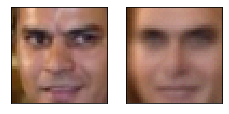

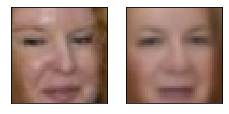

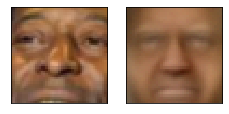

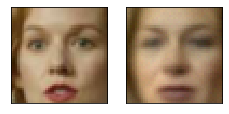

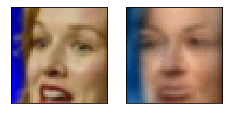

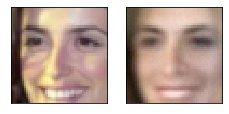

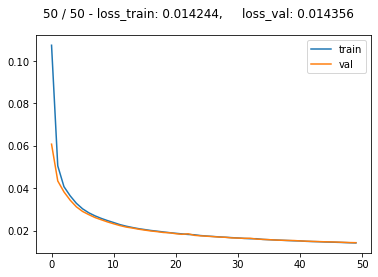

In [ ]:
train(autoencoder_vanilla, X_train, X_val,\
      epochs = 50, loss_func = criterion_vanilla, opt = optimizer_vanilla, batch_size = 128, mode = 'vanilla')

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [ ]:
# < тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>

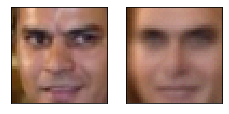

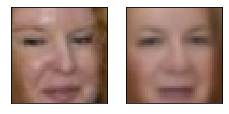

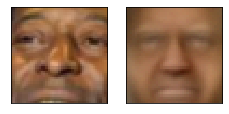

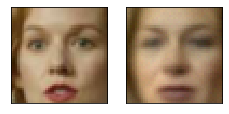

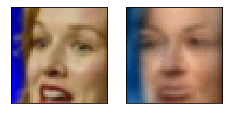

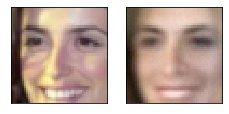

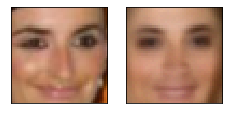

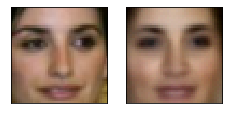

In [ ]:
for k in range(8):
            plot_gallery([np.array(X_val[k]), np.array(autoencoder_vanilla(X_val[k].to(device)\
            .reshape(45 * 45 * 3))[0].view(45, 45, 3).detach().cpu())], 45, 45, n_row=1, n_col=2, mode = 'tensor')
            plt.show()

Not bad, right? 

## Sampling

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

#### If that doesn't work
Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как np.random.randn(25, <latent_space_dim>). А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как лаьентные векторы реальных фоток. Так что ридется рандом подогнать.

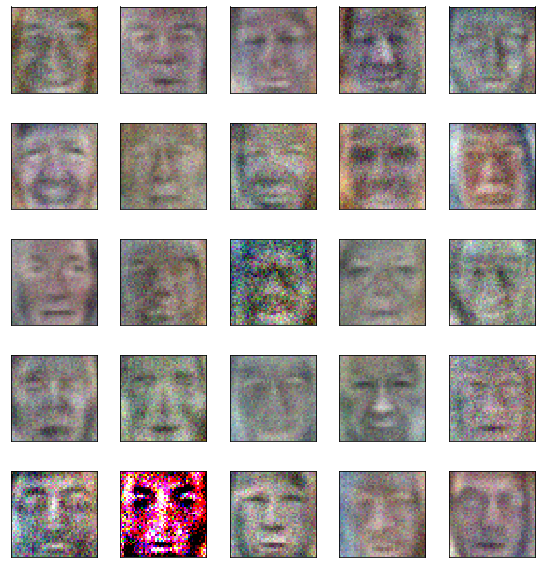

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space
# z = np.random.randn(25, dim_code)
# z = np.random.normal(loc=0, scale=4, size=(25, dim_code))
# z = np.random.pareto(1.5, size=(25, dim_code))
# z = np.random.poisson(0.5, size=(25, dim_code))
# z = np.random.power(10, size=(25, dim_code))
# z = np.random.rayleigh(scale=3, size=(25, dim_code))
# z = np.random.standard_cauchy(size=(25, dim_code))
z = np.random.standard_t(2, size=(25, dim_code)) # тут я пытался экспериментировать с многими распределениями, но с vanilla это работает плохо
# z = np.random.triangular(-3, 0, 8, size=(25, dim_code))
output = autoencoder_vanilla.decoder(torch.from_numpy(z).float().to(device)).view(z.shape[0], 45, 45, 3) # <скормите z декодеру>
plot_gallery(output.data.cpu(), IMAGE_H, IMAGE_W, n_row=5, n_col=5, mode = 'tensor')

## Congrats!

Time to make fun!

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1) Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15 сойдет) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2) Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3) Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

3) А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного чувака и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
# <а вот тут все это надо запрогать, да>

In [ ]:
smiled = attrs.index[attrs['Teeth Not Visible'] < -2.3].tolist() # Возьмём 25 картинок улыбающихся и нет

In [ ]:
not_smiled = attrs.index[attrs['Teeth Not Visible'] > 2.116].tolist()

In [ ]:
len(smiled)

25

In [ ]:
len(not_smiled)

25

In [ ]:
smiled = data[smiled]

In [ ]:
not_smiled = data[not_smiled]

In [ ]:
smiled = to_tensor(smiled)
not_smiled = to_tensor(not_smiled)

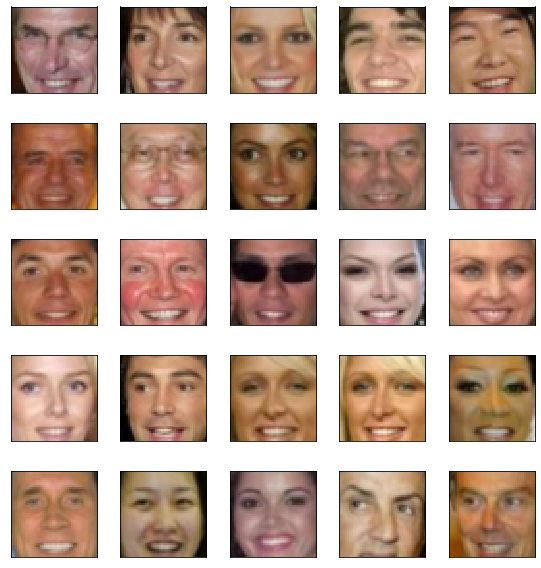

In [ ]:
plot_gallery(smiled, IMAGE_H, IMAGE_W, n_row=5, n_col=5, mode = 'tensor') # Проверим, всё ли так, как нужно

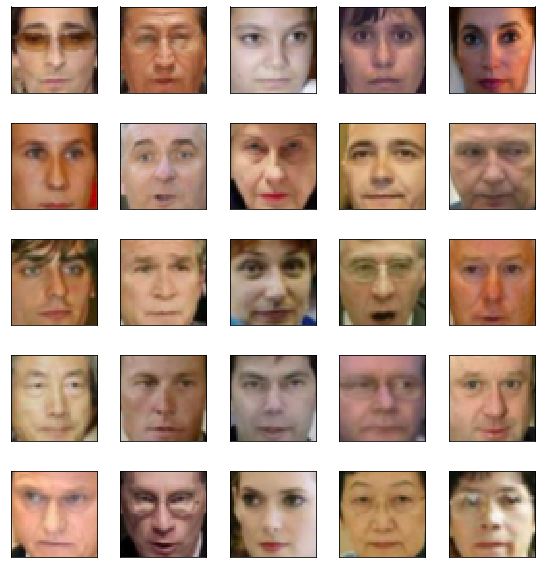

In [ ]:
plot_gallery(not_smiled, IMAGE_H, IMAGE_W, n_row=5, n_col=5, mode = 'tensor')

In [ ]:
latent_smiled = autoencoder_vanilla.encoder(smiled.reshape(smiled.shape[0], 45 * 45 * 3).to(device))

In [ ]:
latent_not_smiled = autoencoder_vanilla.encoder(not_smiled.reshape(smiled.shape[0], 45 * 45 * 3).to(device))

In [ ]:
mean_smiled = torch.mean(latent_smiled, dim = 0)
mean_not_smiled = torch.mean(latent_not_smiled, dim = 0)

In [ ]:
vector = mean_smiled - mean_not_smiled

In [ ]:
latent_not_smiled = vector + latent_not_smiled

In [ ]:
not_smiled_pics = autoencoder_vanilla.decoder(latent_not_smiled).view(latent_not_smiled.shape[0], 45, 45, 3)

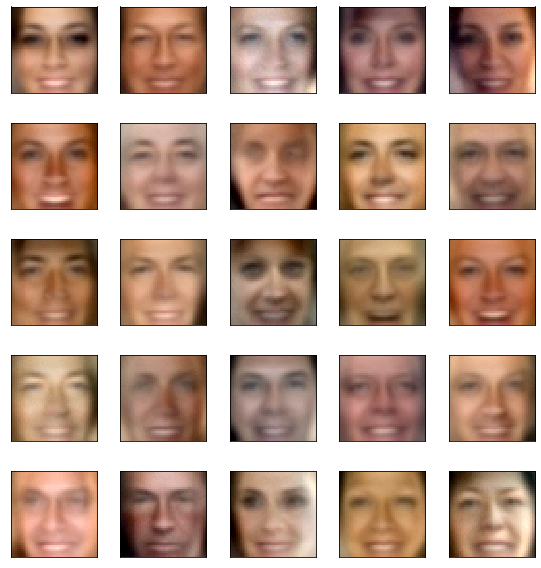

In [ ]:
plot_gallery(not_smiled_pics.detach().cpu(), IMAGE_H, IMAGE_W, n_row=5, n_col=5, mode = 'tensor') # Улыбочку!

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в lwf_deepfinetuned.txt =)

# Variational Autoencoder. (2 балла) 

Представляю вам проапгрейдженную версию автоэнкодеров -- вариационные автоэнкодеры.

https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

In [ ]:
class VAE(nn.Module):
    def __init__(self):
#         <определите архитектуры encoder и decoder
#         помните, у encoder должны быть два "хвоста", 
#         т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
                nn.Linear(28 * 28 * 1, 500),
                nn.BatchNorm1d(500),
                nn.ReLU(),
                nn.Linear(500, 120),
                nn.BatchNorm1d(120), 
                nn.ReLU())
        self.mu_tail = nn.Linear(120, 30)
        self.log_tail = nn.Linear(120, 30)

        self.decoder = nn.Sequential(
                nn.Linear(30, 120),
                nn.BatchNorm1d(120), 
                nn.ReLU(),
                nn.Linear(120, 500),
                nn.BatchNorm1d(500), 
                nn.ReLU(),
                nn.Linear(500, 28 * 28 * 1),
                nn.Sigmoid()
            )

    def encode(self, x):
#         <реализуйте forward проход энкодера
#         в качестве ваозвращаемых переменных -- mu и logsigma>
        en_1 = self.encoder(x)
        mu = self.mu_tail(en_1)
        logsigma = self.log_tail(en_1)
        
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        """
        Функция сэмплирует латентные векторы из нормального распределения с параметрами mu и sigma
        """
        if self.training:
            std = logsigma.exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def decode(self, z):
#         <реализуйте forward проход декодера
#         в качестве ваозвращаемой переменной -- reconstruction>
        reconstruction = self.decoder(z)
        
        return reconstruction

    def forward(self, x):
#         <используя encode и decode, реализуйте forward проход автоэнкодера
#         в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        mu, logsigma = self.encode(x)
        samples = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(samples)
    
        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = - 0.5 * torch.sum(1 + torch.log(1e-8 + torch.pow(logsigma, 2)) - torch.pow(mu, 2) - torch.pow(logsigma, 2)) # <напишите код для KL-дивергенции, пользуясь формулой выше>
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return - loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return -(-KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction))/(28 * 28 * 1 * 128) # Размер картинки, умноженный на батч сайз, чтобы лосс был от 0 до 1 

И обучим модель:

In [ ]:
import torchvision
X_train_mnist = torchvision.datasets.MNIST('/content/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ]))


X_val_mnist = torchvision.datasets.MNIST('/content/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ]))

Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw


Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw


Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw


Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw
Processing...



Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [ ]:
criterion_VAE = loss_vae

autoencoder_VAE = VAE().to(device)

optimizer_VAE = optim.Adam(autoencoder_VAE.parameters(), lr = 0.0002) # <Ваш любимый оптимизатор>

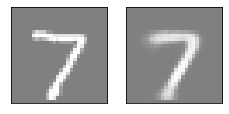

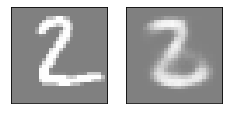

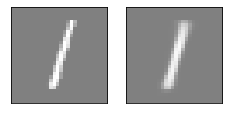

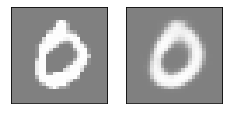

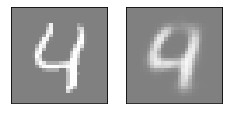

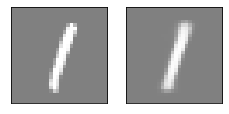

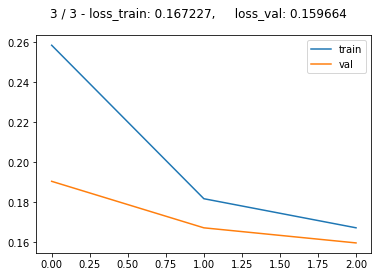

In [ ]:
train(autoencoder_VAE, X_train_mnist, X_val_mnist, epochs = 3, loss_func = criterion_VAE, opt = optimizer_VAE, batch_size = 128, mode = 'VAE')
# Учим 3 эпохи, так как потом вал лосс начинает расти

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

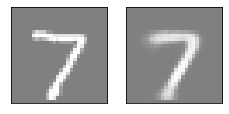

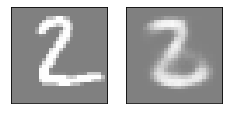

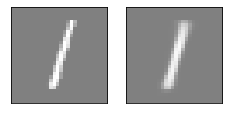

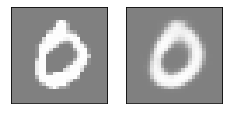

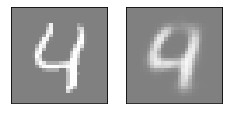

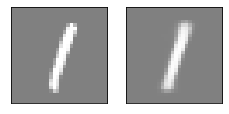

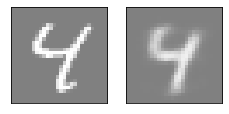

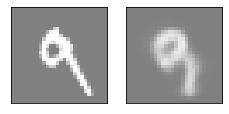

In [ ]:
autoencoder_VAE.eval()
for k in range(8):
            plot_gallery([np.array(X_val_mnist[k][0]), np.array(autoencoder_VAE(X_val_mnist[k][0].to(device)\
            .reshape(1, 28 * 28 * 1))[2].view(1, 28, 28).detach().cpu())], 28, 28, n_row=1, n_col=2, mode = 'MNIST')
            plt.show()

In [ ]:
# < тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>

And finally sample from VAE.

## Sampling

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

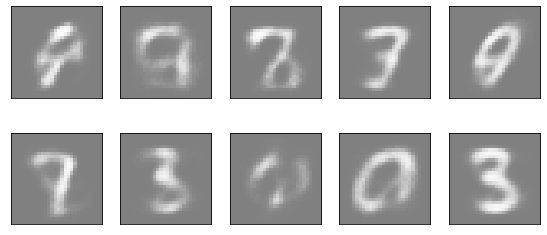

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, 30) for i in range(120)])

# z = np.random.triangular(0, 0.5, 2, size = (10, 30))
output = autoencoder_VAE.decoder(torch.from_numpy(z).float().to(device)).view(z.shape[0], 1, 28, 28)
plot_gallery(output.data.cpu().numpy(), 28, 28, n_row=2, n_col=5, mode = 'MNIST') # уже что-то похожее на правду

## Latent Representation

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы лиц в пространстве. 

Плюс давайте сделаем такую вещь: у вас есть файл с атрибутами lwf_deepfinetuned.txt, который скачался вместе с базой картинок. Там для каждой картинки описаны атрибуты картинки (имя человека, его пол, цвет кожи и т.п.). Когда будете визуализировать точки латентного пространства на картинке, возьмите какой-нибудь атрибут и покрасьте точки в соответствии со значем атрибута, соответствующего этой точке. 

Например, возьмем атрибут "пол". Давайте покрасим точки, которые соответствуют картинкам женщин, в один цвет, а точки, которые соответствуют картинкам мужчин -- в другой.

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю TSNE (есть в sklearn) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью matplotlib.scatter, покрасить разными цветами точки, соответствующие картинкам с разными атрибутами.

In [ ]:
# <ваш код получения латентных представлений, применения TSNE и визуализации>

In [ ]:
test_input = X_val_mnist.data.view(-1, 1, 28, 28).float()

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE()

autoencoder_VAE.eval()
mu, logsigma = autoencoder_VAE.encode(test_input.to(device)\
            .reshape(-1, 28 * 28 * 1))
X = autoencoder_VAE.gaussian_sampler(mu, logsigma)

X_embedded = tsne.fit_transform(X.detach().cpu())


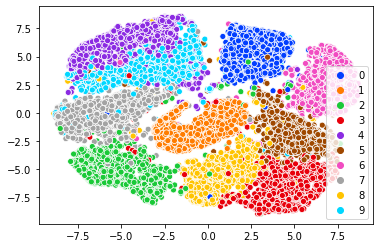

In [ ]:
import seaborn as sns

sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue = X_val_mnist.targets, legend='full', palette = 'bright')

Что вы думаете о виде латентного представления?

Точки разных классов в идеале должны быть расположены близко друг к другу без пробелов и разрывов, чтобы генерация была наилучшей и случайный вектор было бы легко подобрать. Мы видим, что пробелов и разрывов не так много, поэтому и генерация лучше, чем на обычном AE

## Congrats v2.0!

# Conditional VAE (2 балла)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот мне понадобилось сгенерировать цифру 8. И я подставляю разные варианты шума, и все никак не генерится восьмерка -- у меня получаются то пятерки, то тройки, то четверки. Гадость(

  Хотелось бы добавить к нашему AE функцию "выдай мне пожалуйста рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).
  Типа я такая говорю "выдай мне случайную восьмерку" и оно генерит случайную восьмерку!

Conditional AE -- так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части проекта мы научимся такие обучать.

## Архитектура

На картинке ниже представлена архитектура простого Conditional AE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера есть конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). Первый слой декодера есть конкатенация латентного вектора и информации о классе.


![alt text](https://i.ibb.co/2tsWknB/Screen-Shot-2020-01-15-at-9-02-15-PM.png)



На всякий случай: это VAE, то есть, latent у него состоит из mu и sigma все еще.

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

### P.S.
Можно ередавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

### Датасет
Здесь я предлагаю вам два вариана. Один попроще, другой -- посложнее, но поинтереснее =)

1. Использовать датасет MNIST (http://yann.lecun.com/exdb/mnist/). Обучать conditional VAE на этом датасете, condition -- класс цифры. 

2. Использовать датасет лиц, с которым мы игрались выше. Condition -- пол/раса/улыбки/whatever из lfw_deepfinetuned.txt. 

Почему второй вариант "посложнее" -- потому что я сама еще не знаю, получится ли такой CVAE с лицами или нет =) Вы -- исследователи! (не ну это же проект, так и должно быть)

In [ ]:
# <тут ваш код объявления CVAE, лосса, оптимизатора и тренировки>

In [ ]:
class CVAE(nn.Module):
    def __init__(self):
#         <определите архитектуры encoder и decoder
#         помните, у encoder должны быть два "хвоста", 
#         т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
        super(CVAE, self).__init__()
        self.encoder_0 = nn.Sequential(
                nn.Linear(28 * 28 * 1 + cond_dim, 500),
                nn.BatchNorm1d(500),
                nn.ReLU())
        self.encoder_1 = nn.Sequential(nn.Linear(500 + cond_dim, 120),
                nn.BatchNorm1d(120), 
                nn.ReLU())
        self.mu_tail = nn.Linear(120, 30)
        self.log_tail = nn.Linear(120, 30)

        self.decoder_0 = nn.Sequential(
                nn.Linear(30 + cond_dim, 120),
                nn.BatchNorm1d(120), 
                nn.ReLU())
        self.decoder_1 = nn.Sequential(nn.Linear(120 + cond_dim, 500),
                nn.BatchNorm1d(500), 
                nn.ReLU(),
                nn.Linear(500, 28 * 28 * 1),
                nn.Sigmoid()
            )

    def encode(self, x, cond):
#         <реализуйте forward проход энкодера
#         в качестве ваозвращаемых переменных -- mu и logsigma>
        x = torch.cat([x, cond], dim = 1)
        en_1 = self.encoder_0(x)
        en_1 = torch.cat([en_1, cond], dim = 1)
        en_2 = self.encoder_1(en_1)
        mu = self.mu_tail(en_2)
        logsigma = self.log_tail(en_2)
        
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        """
        Функция сэмплирует латентные векторы из нормального распределения с параметрами mu и sigma
        """
        if self.training:
            std = logsigma.exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def decode(self, z, cond):
#         <реализуйте forward проход декодера
#         в качестве ваозвращаемой переменной -- reconstruction>
        z = torch.cat([z, cond], dim = 1)
        dec_0 = self.decoder_0(z)
        dec_0 = torch.cat([dec_0, cond], dim = 1)
        reconstruction = self.decoder_1(dec_0)
        
        return reconstruction

    def forward(self, x, cond):
#         <используя encode и decode, реализуйте forward проход автоэнкодера
#         в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        mu, logsigma = self.encode(x, cond)
        samples = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(samples, cond)
    
        return mu, logsigma, reconstruction

In [ ]:
cond_dim = 10

In [ ]:
criterion_CVAE = loss_vae

autoencoder_CVAE = CVAE().to(device)

optimizer_CVAE = optim.Adam(autoencoder_CVAE.parameters(), lr = 0.0002) # <Ваш любимый оптимизатор>

In [ ]:
def one_hot(labels, class_size, mode = None): # Функция для конкатенации лэйбла и картинки
    if mode != None:
        targets = torch.zeros(len(labels), class_size)
    else:
        targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, int(label)] = 1
    return Variable(targets)

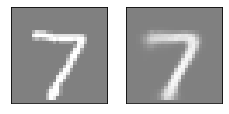

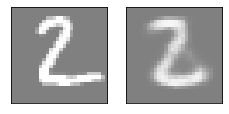

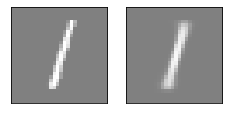

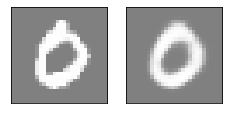

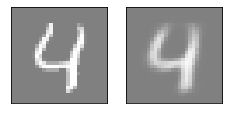

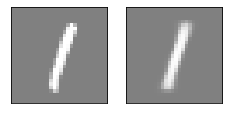

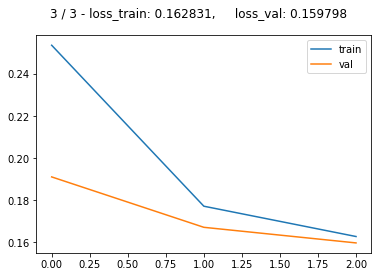

In [ ]:
train(autoencoder_CVAE, X_train_mnist, X_val_mnist, epochs = 3, loss_func = criterion_CVAE, opt = optimizer_CVAE, batch_size = 128, mode = 'CVAE')

## Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора картинки цифры 5 и 7, а для лиц людей -- восстановить лицо улыбающегося и хмурого человека или лица людей разного пола (смотря на чем был ваш кондишен)

In [ ]:
# <тут нужно научиться сэмплировать из декодера цифры определенного класса>

In [ ]:
indexes = []
for i in range(10):
    indexes.append(i)
    
ind = one_hot(indexes, 10, mode = 'list')

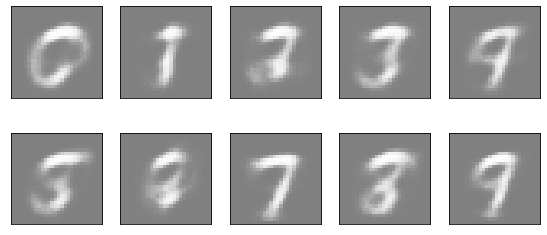

In [ ]:
z = np.array([np.random.normal(0, 1, 30) for i in range(1)]) # Попробуем из 1 вектора восстановить все цифры
a = np.zeros([10, 30])
for i in range(10):
  a[i] = z
output = autoencoder_CVAE.decode(torch.from_numpy(a).float().to(device), ind.to(device)).view(a.shape[0], 1, 28, 28)
plot_gallery(output.data.cpu().numpy(), 28, 28, n_row=2, n_col=5, mode = 'MNIST')

Splendid! Вы великолепны!

Ну круто же, ну?

## Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
# <ваш код получения латентных представлений, применения TSNE и визуализации>

In [ ]:
test_input = X_val_mnist.data.view(-1, 1, 28, 28).float()
test_targets = X_val_mnist.targets.float()

In [ ]:
target = one_hot(test_targets, 10)

In [ ]:
from sklearn.manifold import TSNE

tsne_cvae = TSNE()

autoencoder_CVAE.eval()
mu, logsigma = autoencoder_CVAE.encode(test_input.to(device)\
            .reshape(-1, 28 * 28 * 1), target.to(device))
X_cvae = autoencoder_CVAE.gaussian_sampler(mu, logsigma)

X_embedded_cvae = tsne_cvae.fit_transform(X_cvae.detach().cpu())

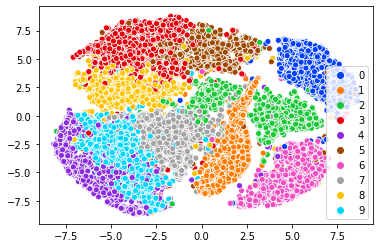

In [ ]:
import seaborn as sns

sns.scatterplot(X_embedded_cvae[:,0], X_embedded_cvae[:,1], hue = X_val_mnist.targets, legend='full', palette = 'bright')

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

Точки стали расположены ближе друг к другу и это положительно сказалось на генерации, и теперь даже из одного вектора можно попытаться сгенерировать все цифры

# BONUS 1: Image Morphing (1 балл) 

<a href="https://ibb.co/rxr9YgL"><img src="https://i.ibb.co/D92dhN6/1-6y-Okto2-BUp-ONJpk5x-LRMtw.png" alt="1-6y-Okto2-BUp-ONJpk5x-LRMtw" border="0"></a>

Предлагаю вам поиграться не только с улыбками, но и с получением из одного человека другого!

План:
1. Берем две картинки разных людей из датасета
2. Получаем их латентные представления X и Y
3. Складываем латентные представления с коэффициентом $\alpha$:
  $$\alpha X + (1-\alpha) Y$$
  где $\alpha$ принимает несколько значений от 0 до 1 
4. Визуализируем, как один человек превращается в другого!

In [ ]:
# <тут ваш код>

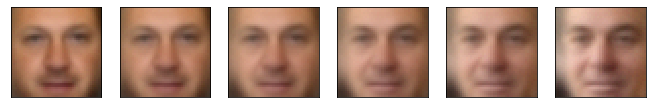

In [ ]:
a = np.random.randint(len(X_val))
b = np.random.randint(len(X_val))

A = autoencoder_vanilla.encoder(X_val[a].to(device).reshape(45 * 45 * 3))
B = autoencoder_vanilla.encoder(X_val[b].to(device).reshape(45 * 45 * 3))

transformation = []
for alpha in np.arange(0, 1.1, 0.2):
    lat = alpha * A + (1 - alpha) * B
    transformation.append(autoencoder_vanilla.decoder(lat).view(45, 45, 3).detach().cpu())

plot_gallery(torch.stack(transformation), 45, 45, n_row=1, n_col=6, mode = 'tensor')

# BONUS 2: Denoising (2 балла) 

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них это бонусное задание.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для того, чтобы поставить эксперимент, нужно взять ваш любимый датасет (датасет лиц или MSE с прошлых заданий или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.25
X_noisy_train = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_noisy_val = X_val + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_val.shape) 

In [ ]:
training_noisy = torch.stack([X_noisy_train.float(), X_train]).transpose(0, 1)

In [ ]:
# <тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>

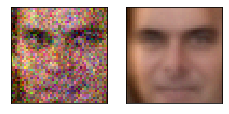

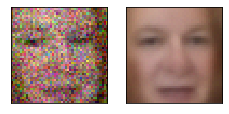

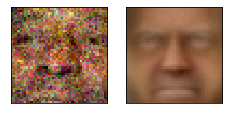

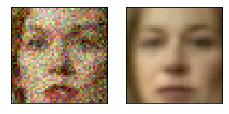

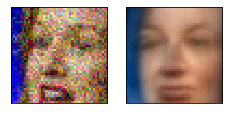

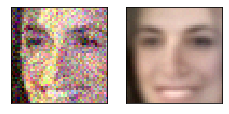

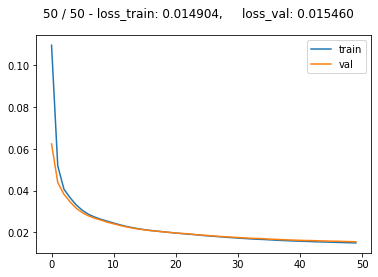

In [ ]:
autoencoder_noisy = Autoencoder(dim_code, inp_size).to(device)
optimizer_noisy = optim.Adam(autoencoder_noisy.parameters(), lr = 0.0001)

train(autoencoder_noisy, training_noisy.float(), X_noisy_val.float(),\
      epochs = 50, loss_func = criterion_vanilla, opt = optimizer_noisy, batch_size = 128, mode = 'noisy_occ', val_data_true = X_val)

In [ ]:
# <тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>

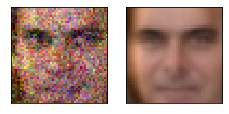

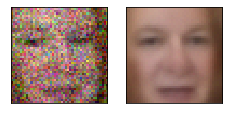

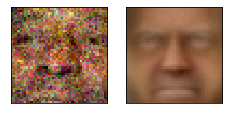

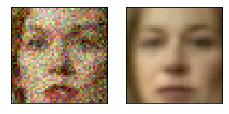

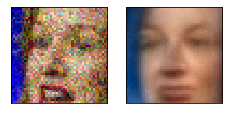

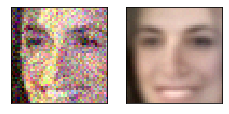

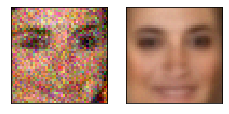

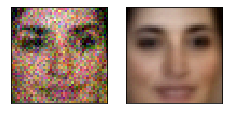

In [ ]:
for k in range(8):
            plot_gallery([np.array(X_noisy_val[k]), np.array(autoencoder_noisy(X_noisy_val[k].float().to(device)\
            .reshape(45 * 45 * 3))[0].view(45, 45, 3).detach().cpu())], 45, 45, n_row=1, n_col=2, mode = 'tensor')
            plt.show()

## Бонус 2.1: Occlusion (+еще 1 балл)

<a href="https://imgbb.com/"><img src="https://i.ibb.co/wYrKtQY/Screen-Shot-2020-06-04-at-5-06-35-PM.png" alt="Screen-Shot-2020-06-04-at-5-06-35-PM" border="0" width="300" height="300"></a>

Автоэнкодерами можно не только убирать шум, но и восстанавливать части картинки, которые чем-то закрыты! 

Эксперимент здесь такой: вместо наложения шума на картинку, "закрываем" часть картинки заплаткой и тренируем AE/VAE восстанавливать закрытую часть картинки.

Важно, чтобы заплатка была не очень большая. 

In [ ]:
# <тут ваш код обучения автоэнкодера на occluded (простите, не знаю, как это сказать по-русски) картинках. Не забудтье разбить на train/test!>

In [ ]:
def zaplatka(dataset):
    for i in range(len(dataset)):
        a = np.random.randint(7, 20)
        b = np.random.randint(7, 20)
        x = np.random.randint(0, 45 - a)
        y = np.random.randint(0, 45 - b)

        for w in range(a):
          for h in range(b):
            for ch in range(3):
              dataset[i][w + x][h + y][ch] = 1.
    return dataset

In [ ]:
dataset = zaplatka(to_tensor(data))

In [ ]:
X_train_z = dataset[:TRAIN_SIZE]
X_val_z = dataset[TRAIN_SIZE:]

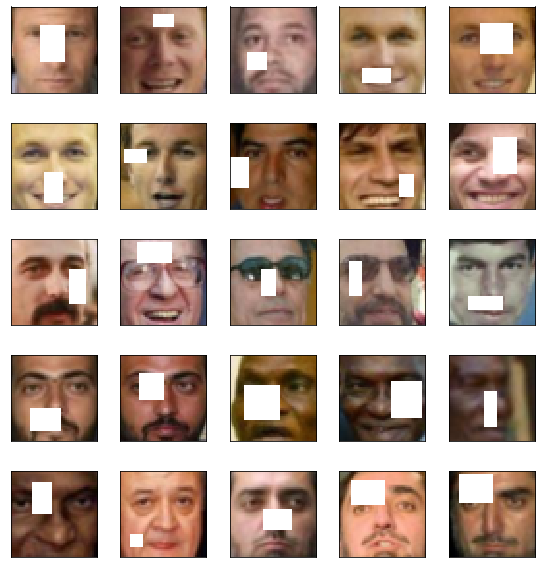

In [ ]:
plot_gallery(X_train_z, 45, 45, 5, 5, mode = 'tensor')

In [ ]:
training = torch.stack([X_train_z, X_train]).transpose(0, 1)

In [ ]:
criterion_occ = nn.MSELoss()

autoencoder_occ = Autoencoder(dim_code, inp_size).to(device)

optimizer_occ = optim.Adam(autoencoder_occ.parameters(), lr = 0.0001) # <Ваш любимый оптимизатор>

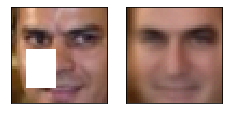

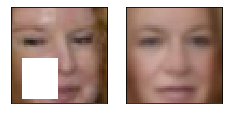

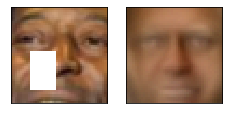

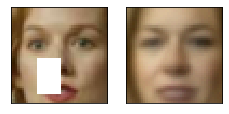

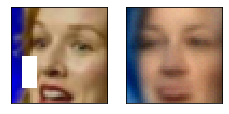

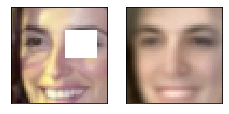

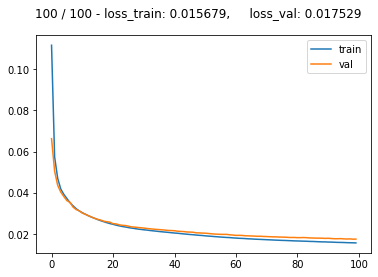

In [ ]:
train(autoencoder_occ, training, X_val_z,\
      epochs = 100, loss_func = criterion_occ, opt = optimizer_occ, batch_size = 128, mode = 'noisy_occ', val_data_true = X_val)

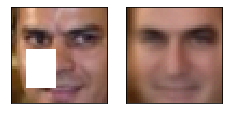

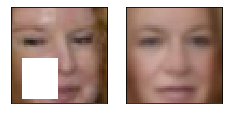

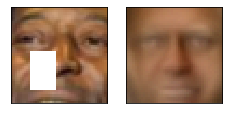

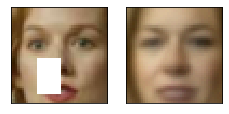

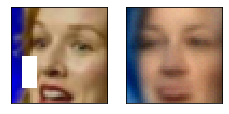

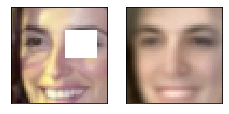

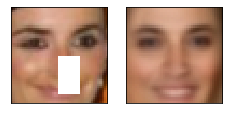

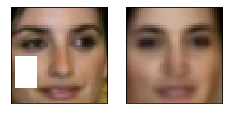

In [ ]:
for k in range(8):
            plot_gallery([np.array(X_val_z[k]), np.array(autoencoder_occ(X_val_z[k].float().to(device)\
            .reshape(45 * 45 * 3))[0].view(45, 45, 3).detach().cpu())], 45, 45, n_row=1, n_col=2, mode = 'tensor')
            plt.show()

# Bonus 3: Image Retrieval (2 балла)

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest (sklearn.neighbors.LSHForest), например, с n_estimators=50
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = autoencoder_vanilla.encoder(X_train.reshape(X_train.shape[0], 45 * 45 * 3).to(device)) # <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes.detach().cpu())

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = autoencoder_vanilla.encoder(image.reshape(1, 45 * 45 * 3).to(device)) # <получение латентного представления image>
    
  (distances,),(idx,) = lshf.kneighbors(code.detach().cpu(), n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    inp = np.array(image, dtype='float32')
    mean = np.array((0.5,0.5,0.5))
    std = np.array((0.5,0.5,0.5))
    inp = std * inp + mean
    plt.imshow(inp)
    plt.title("Original image")
    plt.xticks(())
    plt.yticks(())
    

    for i in range(11):
        plt.subplot(3,4,i+2)
        inp = np.array(neighbors[i], dtype='float32')
        mean = np.array((0.5,0.5,0.5))
        std = np.array((0.5,0.5,0.5))
        inp = std * inp + mean
        plt.imshow(inp)
        plt.title("Dist=%.3f"%distances[i])
        plt.xticks(())
        plt.yticks(())
    plt.show()

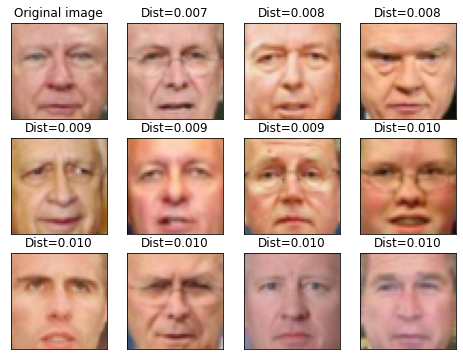

In [ ]:
show_similar(X_val[35].detach().cpu()) # Проверим на рандомной картинке из тестового датасета

# Эпилог

здесь мы рассмотрели не все применения автоэнкодеров. Еще есть, например:

-- поиск аномалий
-- дополнение отсутствующих частей картины
-- работа с sequential данными (например, временными рядами)
-- гибриды ГАН+АЕ, которые активно изучаются в последнее время
-- использование латентных переменных АЕ в качестве фичей
...

Они не были частью этого проекта, потому что для их реализации пришлось бы больше возиться с датасетами. 

Но! Если вы хотите, вы, конечно, всегда можете реализовать еще что-то и получить за это еще допбаллы.

Надеюсь, вам понравилось!

В данном ноутбуке я исследовал некоторые применения автоэнкодеров и мне очень понравилось! Так же я просмотрел некоторые статьи с комбинацией ганов и АЕ (это позволило бы иметь более чёткие реконструкции, например, цифр на VAE), но к сожалению, не хватило времени воплотить данную модель здесь. В прошлом домашнем задании (CycleGAN'ы) была попытка совместить AE и GAN и трансформировать не конечное изображение, а латентное представление (это позволило бы добиться лучших результатов), но не было возможности обучить модель (она обучалась бы очень долго, около 2 суток).
В планах сделать VAE + GAN с лицами и посмотреть, что из этого выйдет! **Спасибо!**